<a href="https://colab.research.google.com/github/jrzkaminski/IndustrialML-ITMO/blob/main/Time_Series_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libs, data importing

In [1]:
!pip install fedot[extra]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 472 kB 4.2 MB/s 
     |████████████████████████████████| 1.6 MB 59.1 MB/s 
     |████████████████████████████████| 2.0 MB 40.8 MB/s 
     |████████████████████████████████| 280 kB 51.9 MB/s 
     |████████████████████████████████| 255.9 MB 39 kB/s 
     |████████████████████████████████| 753 kB 70.5 MB/s 
     |████████████████████████████████| 12.9 MB 9.0 MB/s 
     |████████████████████████████████| 98 kB 8.4 MB/s 
     |████████████████████████████████| 78 kB 7.4 MB/s 
     |████████████████████████████████| 9.9 MB 24.2 MB/s 
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
     |████████████████████████████████| 41 kB 632 kB/s 
     |████████████████████████████████| 316 kB 75.6 MB/s 
     |████████████████████████████████| 44 kB 2.3 MB/s 
     |████████████████████████████████| 4.7 MB 38.0 MB/s 
     |████████████████████████████████| 

In [1]:
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from lightgbm import LGBMRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from datetime import date
from joblib import dump, load

# Configuration
# ==============================================================================
import warnings
import holidays
warnings.filterwarnings('ignore')



In [2]:
!wget https://www.dropbox.com/s/4dw1rn2u3hi5ew4/train_preprocessed.csv -P data
!wget https://www.dropbox.com/s/hiqdtfza0z0fi2l/test.csv -P data
!wget https://www.dropbox.com/s/9z4b0rbak5zrgmh/valid.csv -P data

--2022-11-17 14:02:13--  https://www.dropbox.com/s/4dw1rn2u3hi5ew4/train_preprocessed.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/4dw1rn2u3hi5ew4/train_preprocessed.csv [following]
--2022-11-17 14:02:14--  https://www.dropbox.com/s/raw/4dw1rn2u3hi5ew4/train_preprocessed.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd46fe7db98ee1c4e22464f0c3b.dl.dropboxusercontent.com/cd/0/inline/Bw57ppiG-59A1R2RNz7nhgFa8ONsNxvLPRBwd2j-15WCCGV-j9hMqy86zmcWGAj_9zZKet7HZYKddy34pl6ceQGCpkni4yy_19HPyGbkLwp8sBEhhqM0_REluhec4sAJS48_FSJnu_Loi5RvezrKRVBENFqJR9pwL_JynnDvEB4e9w/file# [following]
--2022-11-17 14:02:15--  https://ucd46fe7db98ee1c4e22464f0c3b.dl.dropboxusercontent.com/cd/0/inline/Bw57ppiG-59A1R2RNz7nhgFa8ONsNxvLPRBwd2j-15WCCGV-j

In [3]:
data_train = pd.read_csv('data/train_preprocessed.csv')
data_train.drop('Unnamed: 0', axis=1, inplace=True)
data_train

,point,lon,lat,time,timestamp,num_posts
0,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-22 11:00:00,1574420400,1
1,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-22 12:00:00,1574424000,1
2,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-23 13:00:00,1574514000,1
3,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-25 16:00:00,1574697600,1
4,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-27 10:00:00,1574848800,1
...,...,...,...,...,...,...
3625651,0101000020E6100000FF9D4C0EC3853E4094782B2D0DF3...,30.522508,59.898840,2019-12-06 04:00:00,3151209600,2
3625652,0101000020E6100000FF9D4C0EC3853E4094782B2D0DF3...,30.522508,59.898840,2019-12-23 08:00:00,1577088000,1
3625653,0101000020E6100000FF9D4C0EC3853E40ABD94A1972EF...,30.522508,59.870670,2019-06-10 09:00:00,1560157200,1
3625654,0101000020E6100000FF9D4C0EC3853E40ABD94A1972EF...,30.522508,59.870670,2019-10-06 14:00:00,1570370400,1


In [4]:
data_test = pd.read_csv('data/test.csv')
data_test

,hour,lat,lon,point,sum,error
0,1582711200,59.934863,30.331616,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,7,0.370265
1,1581937200,59.940488,30.329370,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,6,0.754735
2,1581523200,59.905597,30.297929,0101000020E61000006AEBE80E454C3E407F614299EAF3...,5,3.754735
3,1581512400,59.921359,30.356319,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...,16,4.088069
4,1581771600,59.939363,30.315895,0101000020E61000006141807FDE503E40A554BF083DF8...,10,2.088069
...,...,...,...,...,...,...
695,1582059600,59.926986,30.331616,0101000020E61000009BAC04C2E4543E4070B5CC78A7F6...,6,0.754735
696,1582038000,59.925860,30.295683,0101000020E6100000AB00D6E0B14B3E406379569882F6...,15,1.215399
697,1581926400,59.937113,30.282208,0101000020E6100000328064CC3E483E400C288C4EF3F7...,20,18.754735
698,1582099200,59.933737,30.322632,0101000020E61000009E01B90998523E407AB3D8B484F7...,8,2.754735


In [5]:
data_val = pd.read_csv('data/valid.csv')
data_val

,hour,lat,lon,point,sum,error
0,1582448400,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402
1,1582225200,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.310291
2,1581260400,60.002300,30.295683,0101000020E6100000AB00D6E0B14B3E40CB88A75E4B00...,5,3.754735
3,1581958800,59.935988,30.324878,0101000020E61000005DECCB372B533E40E4A1F770CEF7...,7,0.504735
4,1582779600,59.933737,30.306912,0101000020E6100000669634C7914E3E407AB3D8B484F7...,14,1.554735
...,...,...,...,...,...,...
704,1580659200,59.905597,30.297929,0101000020E61000006AEBE80E454C3E407F614299EAF3...,7,2.254735
705,1581048000,59.950610,30.315895,0101000020E61000006141807FDE503E402B348A98ADF9...,8,6.754735
706,1581656400,59.933737,30.309158,0101000020E6100000268147F5244F3E407AB3D8B484F7...,6,4.754735
707,1580724000,59.931487,30.358565,0101000020E61000008EADE7EACA5B3E40CAE971F73AF7...,8,1.421402


# Time Series solution

Best result is lagged+ridge with metric test/val 0.627/0.661

Add datetime column to test and valid datasets

In [6]:
data_test['datetime'] = pd.to_datetime(data_test['hour'], unit='s')
data_test = data_test.rename(columns={'sum': 'num_posts'})
data_val['datetime'] = pd.to_datetime(data_val['hour'], unit='s')
data_val = data_val.rename(columns={'sum': 'num_posts'})
data_train['datetime'] = pd.to_datetime(data_train['time'])

data_val_points = len(data_val['point'].unique())
point_to_del = '0101000020E610000000000000000000000000000000000000'
data_val = data_val.drop(data_val[data_val.point == point_to_del].index)
assert len(data_val['point'].unique()) == data_val_points - 1

## Code

In [43]:
import logging

import numpy as np
import pandas as pd
from tqdm import tqdm

from fedot.api.main import Fedot
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import TsForecastingParams, Task, TaskTypesEnum
from fedot.core.utils import fedot_project_root
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder
from fedot.core.pipelines.tuning.unified import PipelineTuner
from fedot.core.repository.quality_metrics_repository import RegressionMetricsEnum

logging.raiseExceptions = False


def metrics(y_true: np.array, y_pred: np.array) -> np.array:
  return np.mean(np.abs(y_true - y_pred) / y_pred)


def get_pipeline():
  lagged = PrimaryNode('lagged')
  final_node = SecondaryNode('ridge', nodes_from=[lagged])
  return Pipeline(final_node)


def tune_pipeline(train_input, pipeline):
  tuner = TunerBuilder(train_input.task)\
    .with_tuner(PipelineTuner)\
    .with_metric(RegressionMetricsEnum.MAE)\
    .with_iterations(50) \
    .build(train_input)
  tuned_pipeline = tuner.tune(pipeline)
  return tuned_pipeline

def run_ts_forecasting_example(train, test, pipeline, timeout: float = None):
    validation_blocks = 2

    time_series = pd.concat([train, test])
    # time_series = train

    task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=len(test)))

    idx = pd.to_datetime(time_series['datetime'].values)

    time_series = time_series['num_posts'].values
    train_input = InputData(idx=idx,
                            features=time_series,
                            target=time_series,
                            task=task,
                            data_type=DataTypesEnum.ts)
    train_data, test_data = train_test_data_setup(train_input, validation_blocks=validation_blocks)

    # init model for the time series forecasting
    model = Fedot(problem='ts_forecasting',
                  task_params=task.task_params,
                  timeout=timeout,
                  logging_level=60,
                  n_jobs=1,
                  cv_folds=2, validation_blocks=validation_blocks, preset='fast_train')

    # run AutoML model design in the same way
    pipeline = model.fit(train_data, predefined_model=pipeline)
    # pipeline.show()

    # use model to obtain forecast
    forecast = model.predict(test_data)
    target = np.ravel(test_data.target)
    # print(model.get_metrics(metric_names=['rmse', 'mae', 'mape'], target=target))

    # plot forecasting result
    # model.plot_prediction()

    return target, forecast

## Arima

In [ ]:
%%time
# test dataset
y_true_full = np.array([])
y_pred_full = np.array([])

points = data_test['point'].unique()
for point in tqdm(points):
  df_train = data_train[data_train['point'] == point][['num_posts', 'datetime']]
  df_test = data_test[data_test['point'] == point][['num_posts', 'datetime']]
  y_true, y_pred = run_ts_forecasting_example(train=df_train, test=df_test, pipeline=get_pipeline(), timeout=0.1)
  y_true_full = np.concatenate((y_true_full, y_true[len(y_pred):]))
  y_pred_full = np.concatenate((y_pred_full, y_pred))
  assert y_true_full.shape == y_pred_full.shape

metric_test = metrics(y_true_full, np.round(y_pred_full))
metric_test

100%|██████████| 149/149 [12:16<00:00,  4.94s/it]

CPU times: user 15min 2s, sys: 20min 19s, total: 35min 22s
Wall time: 12min 16s


1.777568571140022

In [ ]:
%%time
# val_dataset
y_true_full = np.array([])
y_pred_full = np.array([])

points = data_val['point'].unique()

for point in tqdm(points):
  df_train = data_train[data_train['point'] == point][['num_posts', 'datetime']]
  df_val = data_val[data_val['point'] == point][['num_posts', 'datetime']]
  y_true, y_pred = run_ts_forecasting_example(train=df_train, test=df_val, pipeline=get_pipeline(), timeout=0.1)
  y_true_full = np.concatenate((y_true_full, y_true[len(y_pred):]))
  y_pred_full = np.concatenate((y_pred_full, y_pred))
  assert y_true_full.shape == y_pred_full.shape

metric_val = metrics(y_true_full, np.round(y_pred_full))
metric_val

100%|██████████| 154/154 [12:16<00:00,  4.78s/it]

CPU times: user 15min 11s, sys: 20min 31s, total: 35min 43s
Wall time: 12min 16s


1.7888708884914513

## Lagged + ridge

In [ ]:
%%time
# test dataset
y_true_full = np.array([])
y_pred_full = np.array([])

points = data_test['point'].unique()
for point in tqdm(points):
  df_train = data_train[data_train['point'] == point][['num_posts', 'datetime']]
  df_test = data_test[data_test['point'] == point][['num_posts', 'datetime']]
  y_true, y_pred = run_ts_forecasting_example(train=df_train, test=df_test, pipeline=get_pipeline(), timeout=0.1)
  y_true_full = np.concatenate((y_true_full, y_true[len(y_pred):]))
  y_pred_full = np.concatenate((y_pred_full, y_pred))
  assert y_true_full.shape == y_pred_full.shape

metric_test = metrics(y_true_full, np.round(y_pred_full))
metric_test

100%|██████████| 149/149 [05:33<00:00,  2.24s/it]

CPU times: user 5min 34s, sys: 34.2 s, total: 6min 8s
Wall time: 5min 33s


0.6268983178001624

In [ ]:
%%time
# val_dataset
y_true_full = np.array([])
y_pred_full = np.array([])

points = data_val['point'].unique()

for point in tqdm(points):
  df_train = data_train[data_train['point'] == point][['num_posts', 'datetime']]
  df_val = data_val[data_val['point'] == point][['num_posts', 'datetime']]
  y_true, y_pred = run_ts_forecasting_example(train=df_train, test=df_val, pipeline=get_pipeline(), timeout=0.1)
  y_true_full = np.concatenate((y_true_full, y_true[len(y_pred):]))
  y_pred_full = np.concatenate((y_pred_full, y_pred))
  assert y_true_full.shape == y_pred_full.shape

metric_val = metrics(y_true_full, np.round(y_pred_full))
metric_val

100%|██████████| 154/154 [05:39<00:00,  2.20s/it]

CPU times: user 5min 40s, sys: 34.5 s, total: 6min 14s
Wall time: 5min 39s


0.6608872051930477

## Lagged + RF

In [ ]:
%%time
# test dataset
y_true_full = np.array([])
y_pred_full = np.array([])

points = data_test['point'].unique()
for point in tqdm(points):
  df_train = data_train[data_train['point'] == point][['num_posts', 'datetime']]
  df_test = data_test[data_test['point'] == point][['num_posts', 'datetime']]
  y_true, y_pred = run_ts_forecasting_example(train=df_train, test=df_test, pipeline=get_pipeline(), timeout=0.1)
  y_true_full = np.concatenate((y_true_full, y_true[len(y_pred):]))
  y_pred_full = np.concatenate((y_pred_full, y_pred))
  assert y_true_full.shape == y_pred_full.shape

metric_test = metrics(y_true_full, np.round(y_pred_full))
metric_test

100%|██████████| 149/149 [11:30<00:00,  4.63s/it]

CPU times: user 11min 24s, sys: 6.45 s, total: 11min 31s
Wall time: 11min 30s


0.8134295351810639

In [ ]:
%%time
# val_dataset
y_true_full = np.array([])
y_pred_full = np.array([])

points = data_val['point'].unique()

for point in tqdm(points):
  df_train = data_train[data_train['point'] == point][['num_posts', 'datetime']]
  df_val = data_val[data_val['point'] == point][['num_posts', 'datetime']]
  y_true, y_pred = run_ts_forecasting_example(train=df_train, test=df_val, pipeline=get_pipeline(), timeout=0.1)
  y_true_full = np.concatenate((y_true_full, y_true[len(y_pred):]))
  y_pred_full = np.concatenate((y_pred_full, y_pred))
  assert y_true_full.shape == y_pred_full.shape

metric_val = metrics(y_true_full, np.round(y_pred_full))
metric_val

100%|██████████| 154/154 [11:38<00:00,  4.54s/it]

CPU times: user 11min 32s, sys: 7.15 s, total: 11min 39s
Wall time: 11min 38s


0.9542561805345262

## Visualisation

### Popular cube

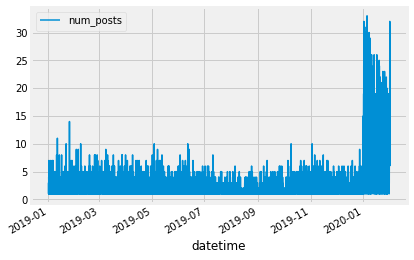

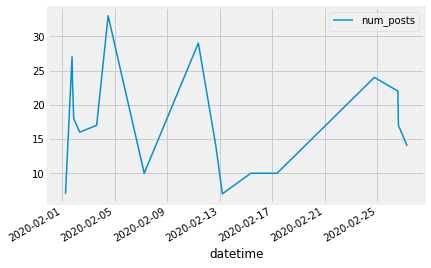

In [44]:
points = data_val['point'].unique()
point = points[39]
df_train = data_train[data_train['point'] == point][['num_posts', 'datetime']]
df_train.plot('datetime', 'num_posts')
df_test = data_test[data_test['point'] == point][['num_posts', 'datetime']]
df_test.plot('datetime', 'num_posts')

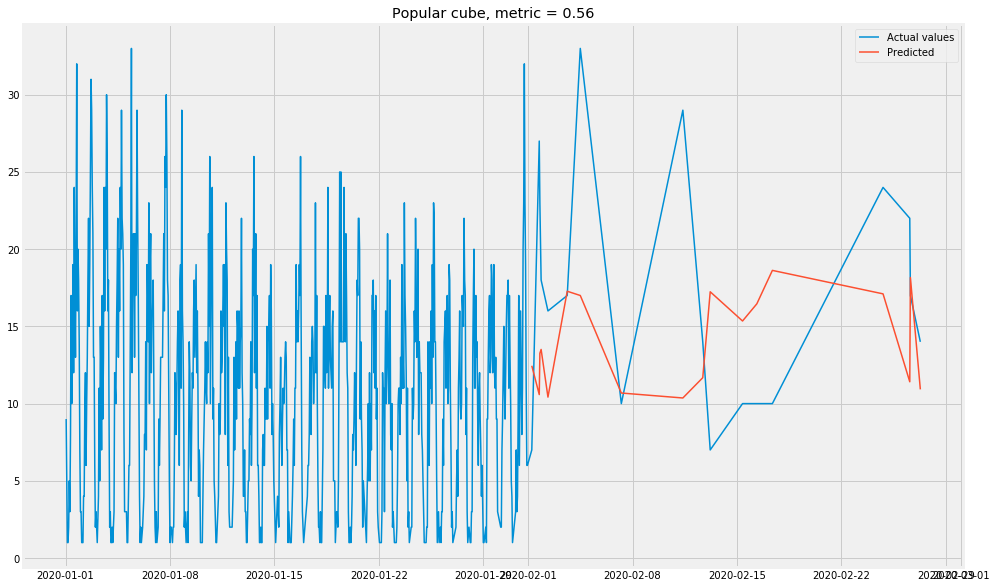

In [45]:
y_true, y_pred = run_ts_forecasting_example(train=df_train, test=df_test, pipeline=get_pipeline(), timeout=0.1)

test_plot_data = pd.DataFrame(data={'datetime': df_test['datetime'], 'predicted': y_pred}).sort_values(by='datetime').set_index('datetime')
train_plot = pd.concat([df_train[df_train['datetime'] > '2020-01-01'], df_test.sort_values(by='datetime')]).set_index('datetime')

plt.figure(figsize=(15,10))
plt.grid()
plt.plot(train_plot, label='Actual values')
plt.plot(test_plot_data, label='Predicted')
plt.grid()
plt.legend(loc='Left corner')
plt.title(f'Popular cube, metric = {np.round(metrics(y_true[len(y_pred):], y_pred), 3)}')
plt.show()

### Unpopular cube

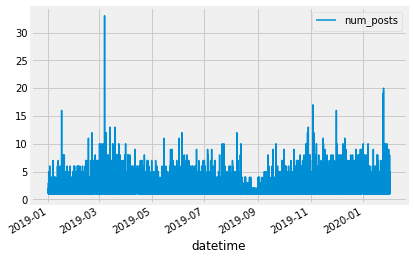

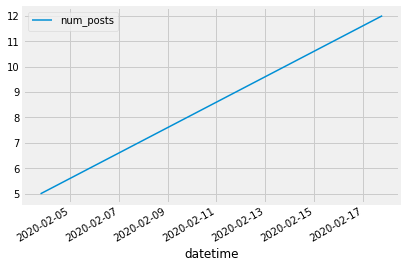

In [46]:
points = data_val['point'].unique()
point = points[2]
df_train = data_train[data_train['point'] == point][['num_posts', 'datetime']]
df_train.plot('datetime', 'num_posts')
df_test = data_test[data_test['point'] == point][['num_posts', 'datetime']]
df_test.plot('datetime', 'num_posts')

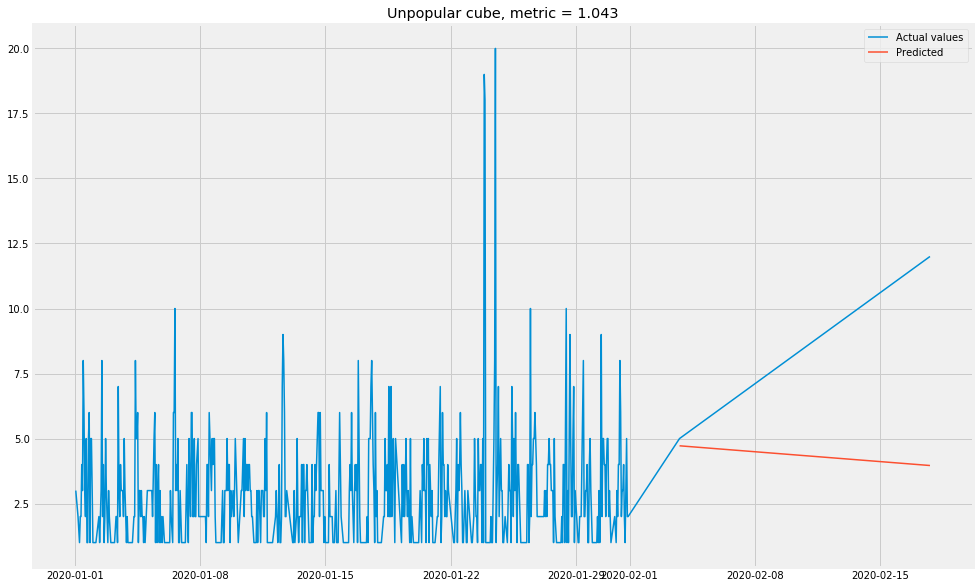

In [48]:
y_true, y_pred = run_ts_forecasting_example(train=df_train, test=df_test, pipeline=get_pipeline(), timeout=0.1)

test_plot_data = pd.DataFrame(data={'datetime': df_test['datetime'], 'predicted': y_pred}).sort_values(by='datetime').set_index('datetime')
train_plot = pd.concat([df_train[df_train['datetime'] > '2020-01-01'], df_test.sort_values(by='datetime')]).set_index('datetime')

plt.figure(figsize=(15,10))
plt.grid()
plt.plot(train_plot, label='Actual values')
plt.plot(test_plot_data, label='Predicted')
plt.grid()
plt.legend(loc='Left corner')
plt.title(f'Unpopular cube, metric = {np.round(metrics(y_true[len(y_pred):], y_pred), 3)}')
plt.show()